# RC Temporal Subsampling
## Old NRMSE and Old NRMSE + KE NRMSE Macro Cost

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, BigPlot, plot_ke_relerr, MetricsPlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
rcd = RCDataset(
    n_sub=[1,4,16],
    cost_terms = [
        {"nrmse": 1},
        {"nrmse": 1, "spectral": 0.0001},
        {"nrmse": 1, "spectral": 0.001},
        {"nrmse": 1, "spectral": 0.01},
        # this one is just shit
        #{"nrmse": 1, "global-integral": 0.0001},
    ],
    old_nrmse=True,
)

In [6]:
rcmacro100 = RCDataset(
    n_sub=[16],
    cost_terms=[
        {"nrmse": 1},
    ],
    n_macro=100,
    old_nrmse=True,
)

In [7]:
%%time
ds = rcd()

CPU times: user 35.4 s, sys: 9.24 s, total: 44.6 s
Wall time: 37 s


In [8]:
ds["gamma"] = xr.DataArray([0., 1e-4, 1e-3, 1e-2], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

Grab one sample for some plotting

In [42]:
xds = ds.sel(sample=49,
             n_sub=16,
             gamma=[0, 1e-4, 1e-2])


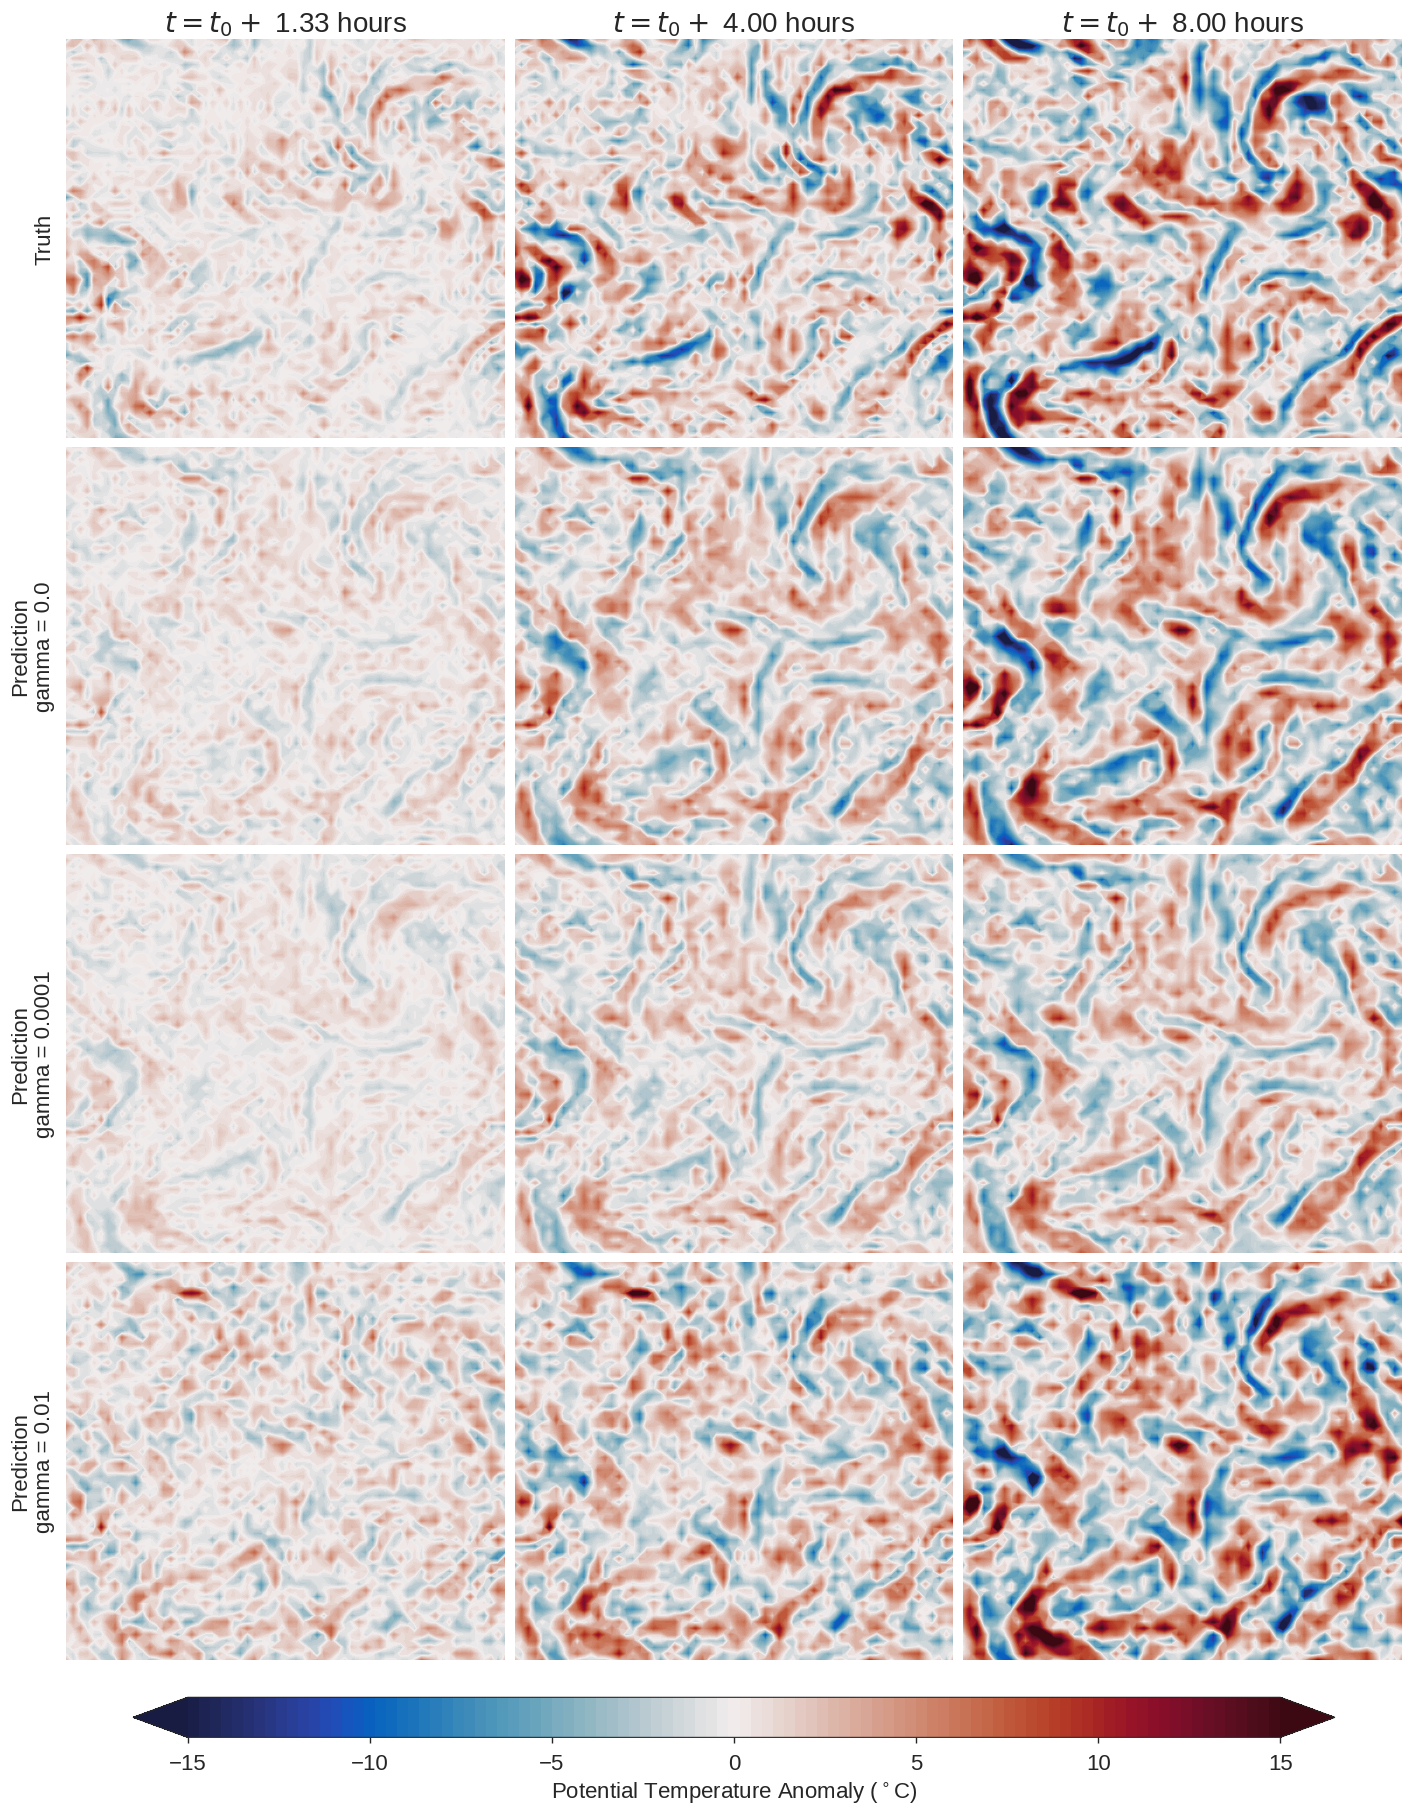

In [43]:
bp = BigPlot()
fig, axs = bp(xds, row_dim="gamma")

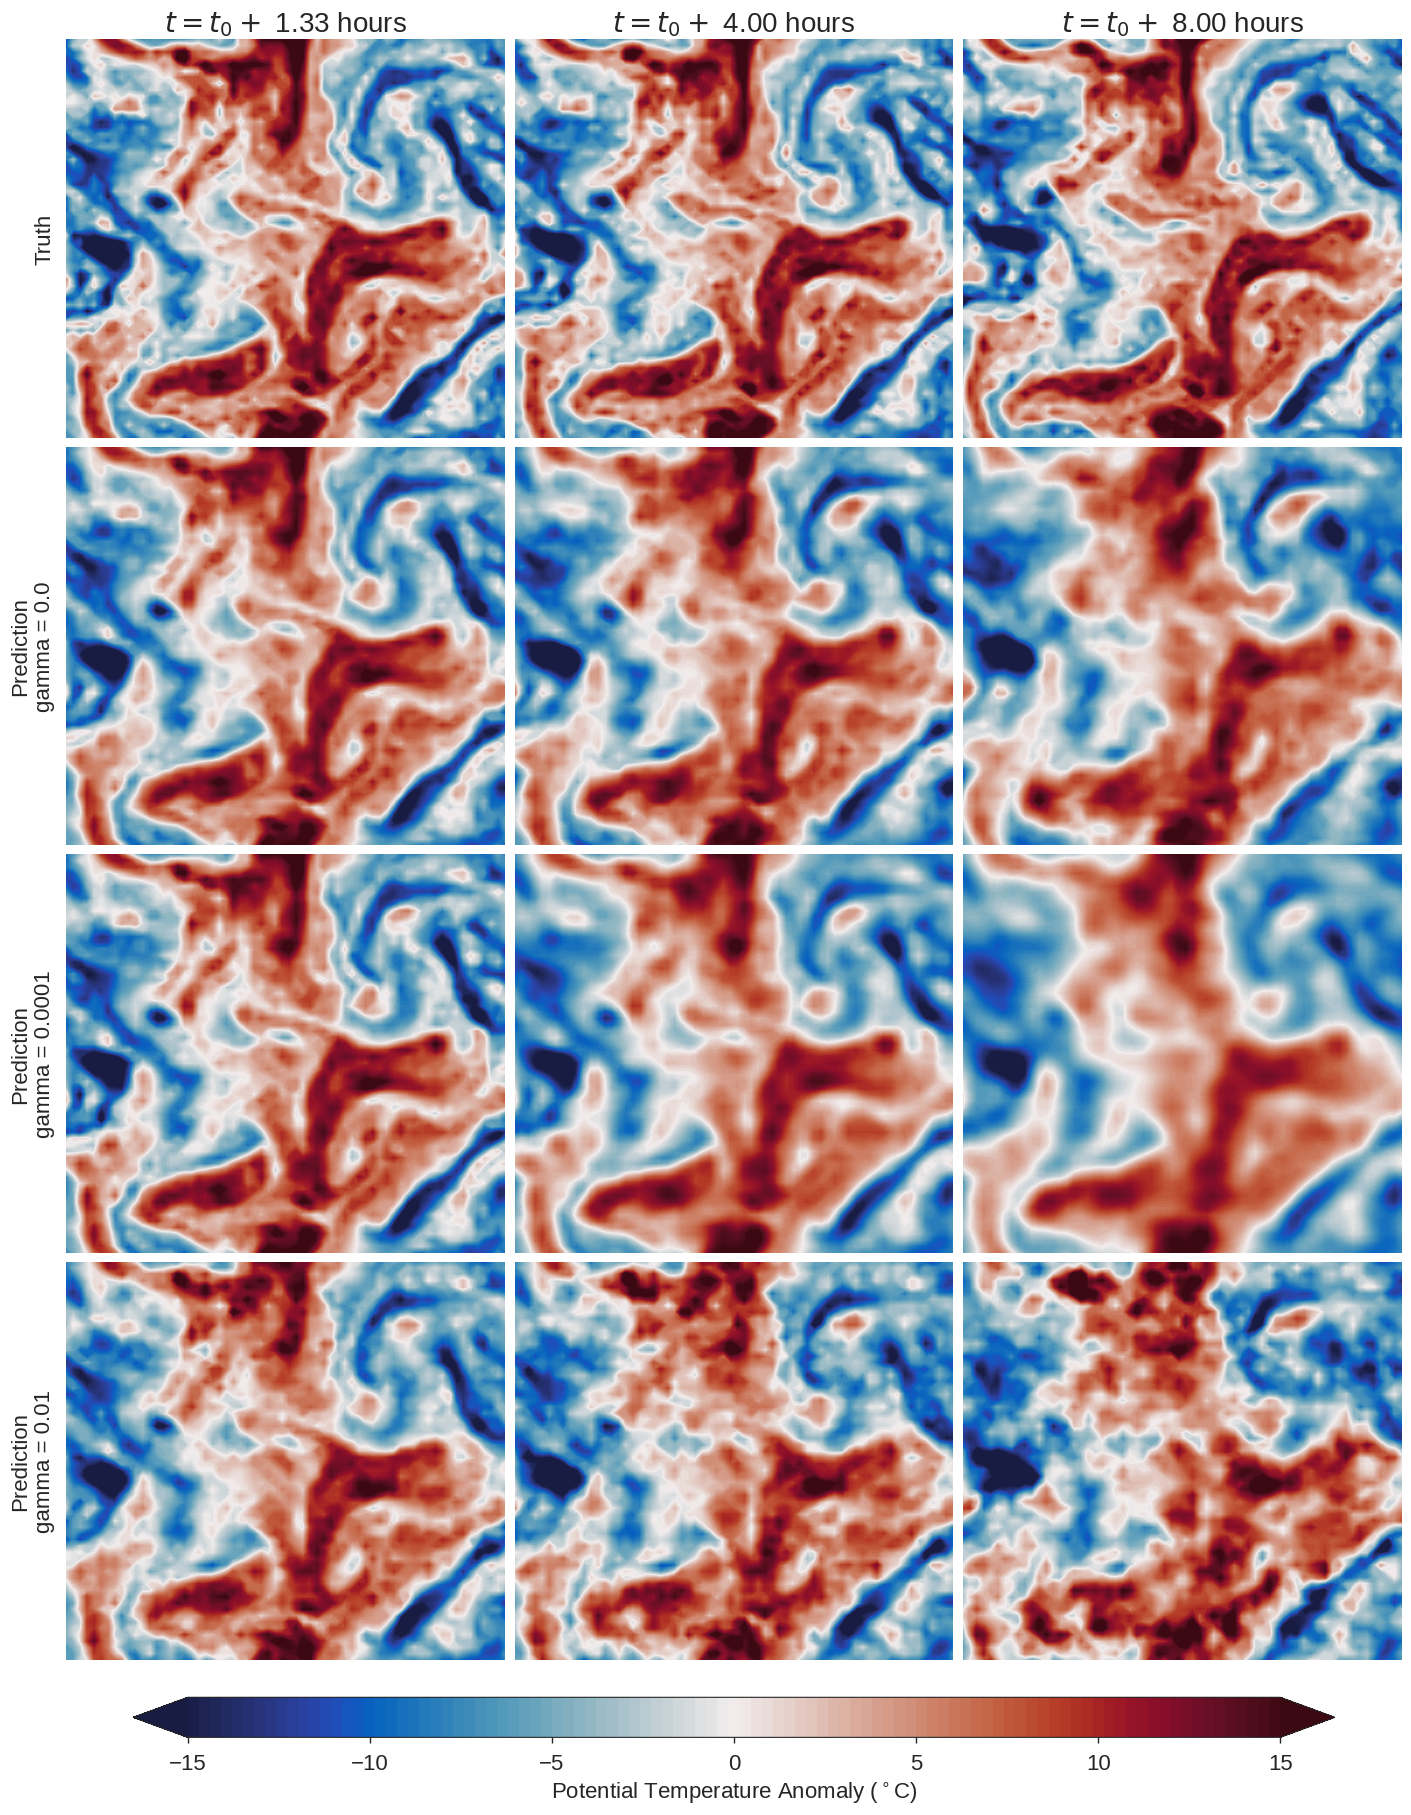

In [44]:
bp = BigPlot(diff_t0=False)
fig, axs = bp(xds, row_dim="gamma")

## Metrics

In [14]:
ds["nrmse"].load();

In [ ]:
def exp_label(exp):
    macro = 10
    if "macro" in exp:
        exp = exp.replace("-100macro", "")
        macro = 100
    split = exp.split("-spectral")
    alpha = split[0].split("nrmse")[-1]
    beta = 0 if len(split)==1 else split[1].split("spectral")[-1]
    
    alpha = int(np.log10(float(alpha)))
    beta = float(beta)
    beta = int(np.log10(beta)) if beta != 0 else -16
    
    a = r"$\alpha = 10^{%d}$" % alpha
    b = r"$\beta = 10^{%d}$" % beta
    c = r"$N=%d$" % macro
    if macro > 10:
        return f"{a}, {b}, {c}"
    else:
        return f"{a}, {b}"

## Fix $N_{sub}$, compare macro cost penalty

### $N_{sub} = 16$

In [25]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="gamma",
)

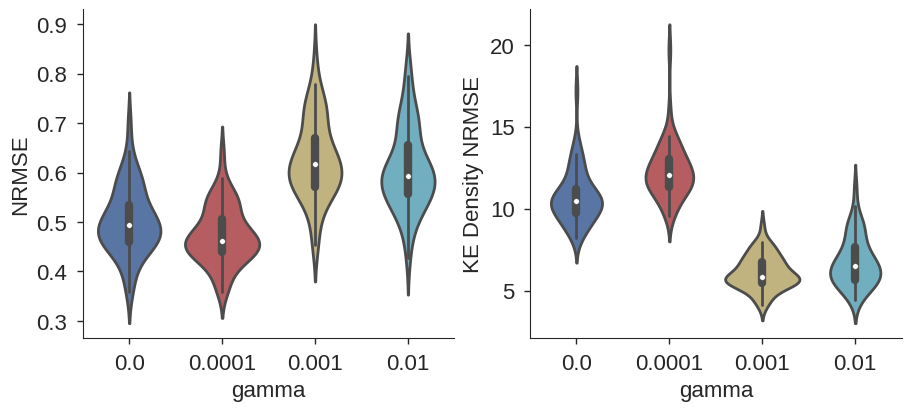

In [26]:
fig, axs = mp(ds.sel(n_sub=16), show_time=False)

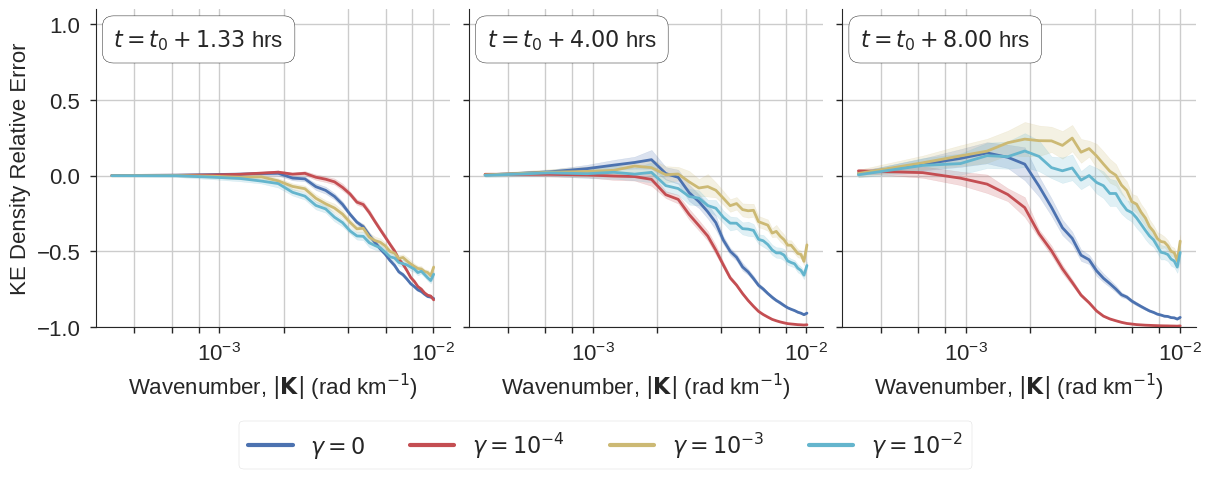

In [20]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=16),
    cdim="gamma",
    clabel=mp.gamma_label,
)

### $N_{sub}=4$

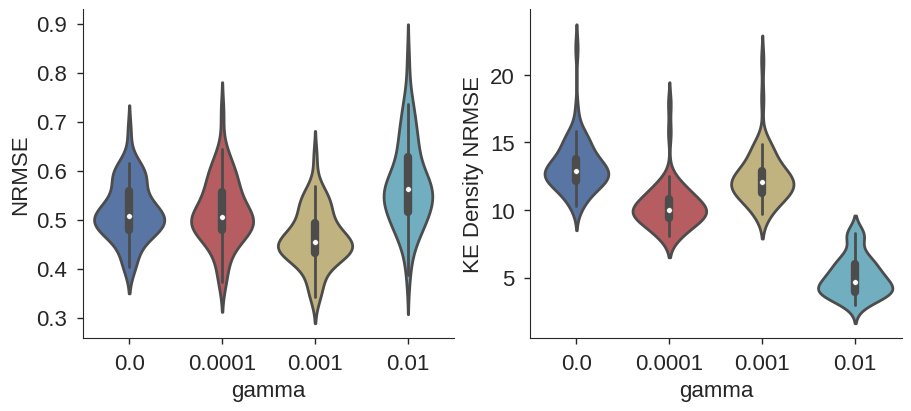

In [27]:
fig, axs = mp(ds.sel(n_sub=4), show_time=False)

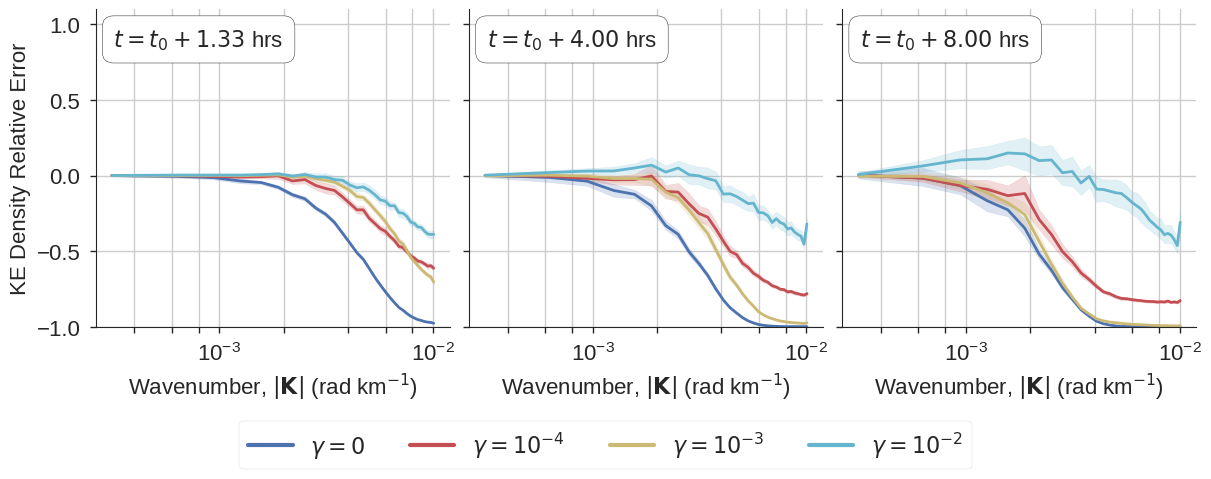

In [22]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=4),
    cdim="gamma",
    clabel=mp.gamma_label,
)

### $N_{sub}=1$

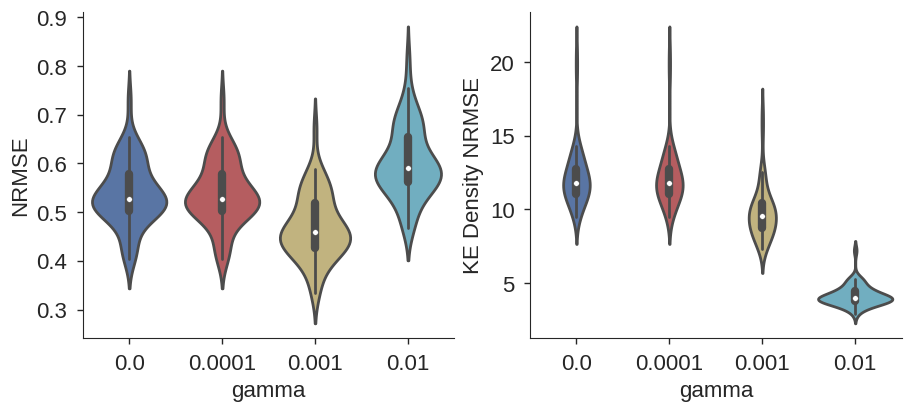

In [28]:
fig, axs = mp(ds.sel(n_sub=1), show_time=False)

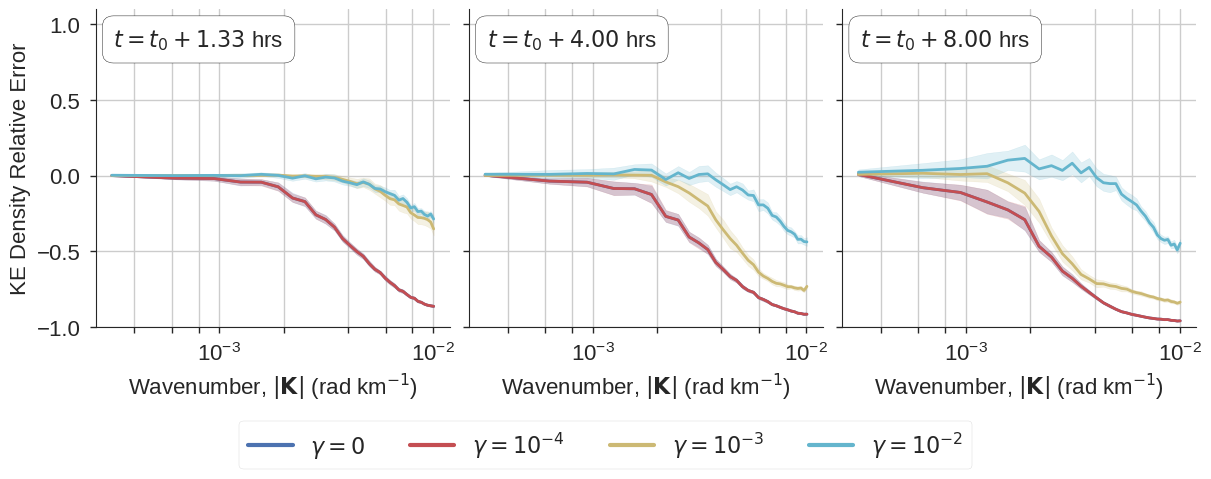

In [24]:
fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(n_sub=1),
    cdim="gamma",
    clabel=mp.gamma_label,
)

## Best spectral representation for each $N_{sub}$

In this case, we can approximately say it's just with the highest $\gamma$... which makes sense

In [49]:
nsubp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="n_sub",
)

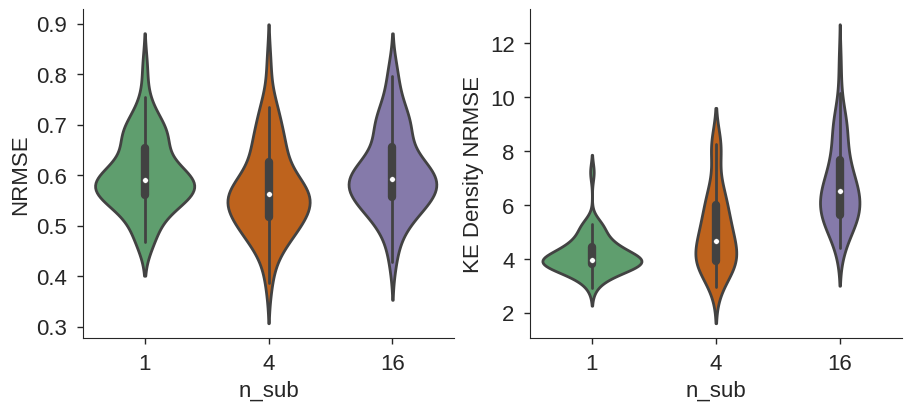

In [60]:
fig, axs = nsubp(ds.sel(gamma=0.01), show_time=False, split=True)

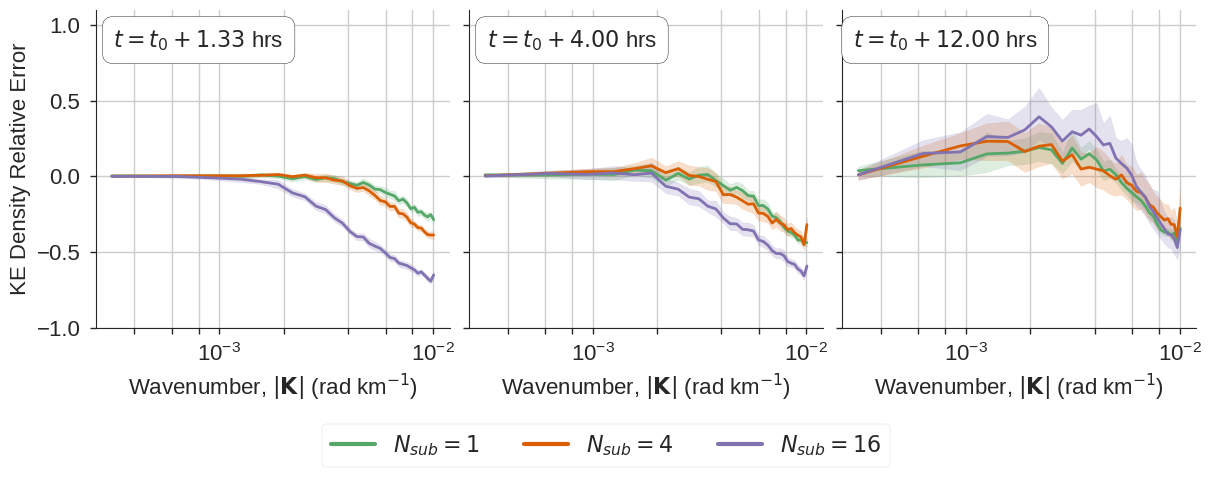

In [61]:
fig, axs = plot_ke_relerr(ds["ke_rel_err"].sel(gamma=0.01), cdim="n_sub", hours=(1.33, 4, 12))

### How do experiments compare to situation with Nmacro=100?

In [36]:
ds2 = rcmacro100()
ds2 = ds2.expand_dims({"gamma": [100]})

In [38]:
dsm = xr.concat([ds.sel(n_sub=16), ds2], dim="gamma")

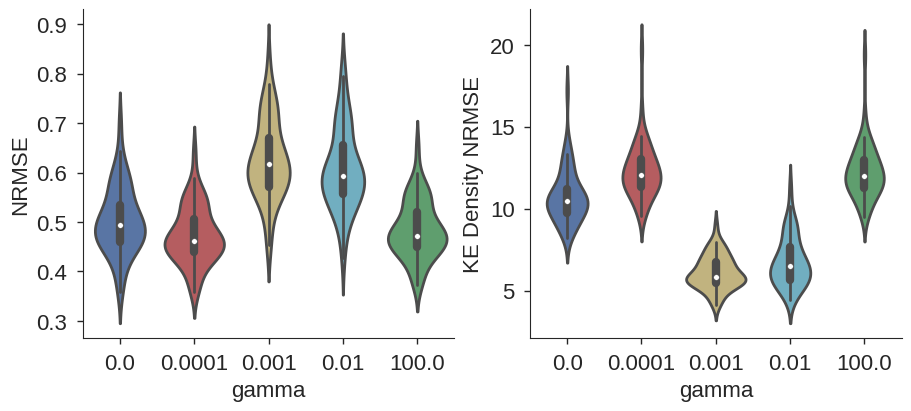

In [39]:
fig, axs = mp(dsm, show_time=False)

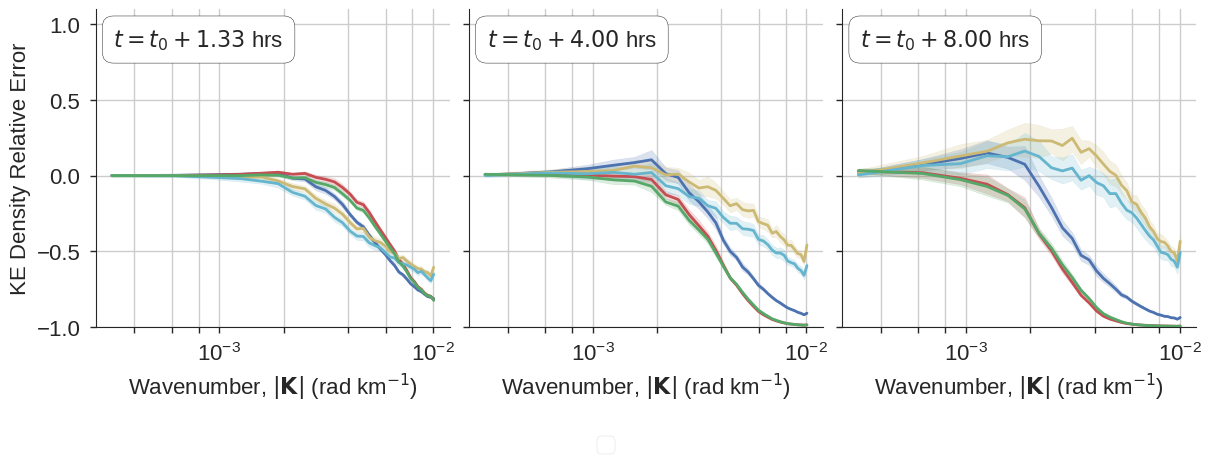

In [41]:
fig, axs = plot_ke_relerr(dsm["ke_rel_err"], cdim="gamma")

- Using $N_{macro} = 100$ provides little benefit over NRMSE on its own (more nuanced than that)
- NRMSE is slightly improved, KE Density NRMSE slightly worse
- Parameters and results are essentially the same when $\gamma = 10^{-4}$